# U_Netによる生成モデルの作成
高解像度画像の生成を目標とし, AEと構造が似ているU_Netと比較を行う.
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab_Notebooks/Unet/"

Mounted at /content/drive/
/content/drive/MyDrive/Colab_Notebooks/Unet


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

データセットはcirfar_10を使用する.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set = datasets.CIFAR10(root='/content/drive/MyDrive/Colab_Notebooks/', 
                             train=True,
                             download=True,
                             transform=transform)

test_set = datasets.CIFAR10(root='/content/drive/MyDrive/Colab_Notebooks/', 
                             train=False,
                             download=True,
                             transform=transform)


Files already downloaded and verified
Files already downloaded and verified


## データの作成
デコード時の出力を入力サイズより大きくしたい.
<br>出力の教師データを作成するためにアップサンプルを行う.
<br>引数
<br>images : cirfarから使用する画像枚数
<br>height, wide : cirfarの縦横
<br>scale_factor : torch.nn.Upsampleのheight, wideの拡大係数
<br>mode : torch.nn.Upsampleの拡大方法





In [ ]:
def upsampler(target, images=1000, height=32, wide=32, scale_factor=2, mode='nearest'):
    m = nn.Upsample(scale_factor=scale_factor, mode=mode)
    out_put = torch.empty(images, 3, height*scale_factor, wide*scale_factor)
    for i, trg in enumerate(target):
        img = trg[0].reshape(-1, 3, 32, 32)    # torch.nn.Upsampleの仕様上、次元を4次元へ
        img = m(img)[0]
        out_put[i] = img
        if i == (images-1): break
    
    return out_put

<br>訓練データを64×64のサイズ、教師データを128×128のサイズにアップサンプリングする.
<br>訓練に使用するイメージ枚数は1万枚.

訓練データ :  torch.Size([3, 64, 64])
教師データ :  torch.Size([3, 128, 128])



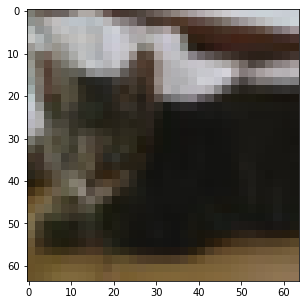

In [ ]:
x_train = upsampler(train_set, images=10000) # 2倍に拡大
y_train = upsampler(train_set, images=10000, scale_factor=4, mode='bilinear') # 4倍に拡大

x_test = upsampler(train_set, images=100)
y_test = upsampler(train_set, images=100, scale_factor=4, mode='bilinear')
print('訓練データ : ', x_train[0].shape)
print('教師データ : ', y_train[0].shape)
print()
new_img = np.transpose(x_train[9], (1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(new_img)

## アーキテクチャ
AEとU_Netの構造を切り替えられるようにu_netのフラグを引数として用意した.
<br>エンコードは3×64×64を512×4×4に, デコードでは512×4×4を3×128×128へアップサンプリング.
<br>エンコード時のフィルターは3, デーコード時のフィルターは4.
<br>paddingは1, strideは2.

In [ ]:
class Model(nn.Module):


    def __init__(self, hidden_dim, u_net):
        super(Model, self).__init__()
        stride = 2
        padding = 1
        self.u_net = u_net
        # エンコーディング・レイヤー
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, stride=stride, padding=padding), 
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*8, 3, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU()   
        )

        # デコーディング・レイヤー
        self.layer_5 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*8, hidden_dim*4, 4, stride=stride, padding=padding), 
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.layer_6 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.layer_7 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.layer_8 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, int(hidden_dim/2), 4, stride=stride, padding=padding), 
            nn.BatchNorm2d(int(hidden_dim/2)),
            nn.ReLU()
        )
        self.layer_9 = nn.Sequential(
            nn.ConvTranspose2d(int(hidden_dim/2), 3, 4, stride=stride, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )

        self.encode_sequence = [self.layer_1, self.layer_2, self.layer_3, self.layer_4]
        self.decode_sequence = [self.layer_5, self.layer_6, self.layer_7, self.layer_8, self.layer_9]


    def forward(self, x):

        encoded_layer = deque([])
        for en in self.encode_sequence:
            x = en(x)
            if self.u_net: # u_netがTrueであればencoded_layerに情報を格納
                encoded_layer.append(x)

        for de in self.decode_sequence:
            if self.u_net:
                if deque([]) != encoded_layer: # encoded_layerに情報があればdequeで取り出す
                    x = x + encoded_layer.pop()
            x = de(x)
            
        return x

## モデルの学習
損失関数はMSEを使用する.

In [ ]:
num_epochs = 1
batch_size = 1000
u_net = [True, False]
learning_rate = 1e-3


# upsamperで設定した枚数をバッチサイズで分割
# 訓練データ
samples_size, _, x_height, x_wide = x_train.shape
_, _, y_height, y_wide = y_train.shape
x_trains = x_train.reshape(samples_size//batch_size, -1 , 3, x_height, x_wide)
y_trains = y_train.reshape(samples_size//batch_size, -1 , 3, y_height, y_wide)
# テストデータ
x_tests = x_test.reshape(-1, 3, x_height, x_wide)
y_tests = y_test.reshape(-1, 3, y_height, y_wide)


loss_dict = {}
test_loss_dict = {}


for flg in u_net: # U_netとAEをフラグで切り替える
    loss_list = []

    # モデルの定義
    model = Model(hidden_dim=x_height, u_net=flg).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 訓練
    for epoch in range(num_epochs):
        
        for idx, data in enumerate(x_trains):
            data = data.to(device)
            out_put = model(data)

            loss = criterion(out_put, y_trains[idx].to(device))
            loss_list.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    loss_dict[str(flg)+'_'+str(batch_size)] = loss_list

    # テストデータでlossの評価
    test_data = x_tests.to(device)
    test_out_put = model(test_data)
    test_loss = criterion(test_out_put, y_tests.to(device))
    test_loss_dict[str(flg)+'_'+str(batch_size)] = float(test_loss)
    # モデルの保存
    model_path = 'u_net_{}_{}.pth'.format(str(flg), str(batch_size))
    torch.save(model.state_dict(), model_path)

## 損失について
batch_size = 1000 における訓練時の損失
<br>TrueがU_Net, FalseがAE.
<br>U_Netの方がlossが小さくエンコード時の情報が貢献していることが確認できる.

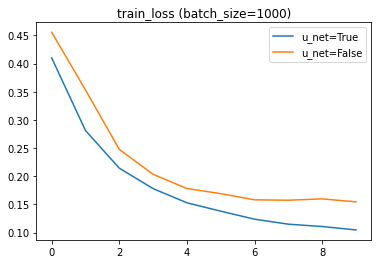

In [ ]:
plt.plot(loss_dict['True_1000'], label='u_net=True')
plt.plot(loss_dict['False_1000'], label='u_net=False')
plt.title('train_loss (batch_size=1000)')

plt.legend()

In [ ]:
print('u_net=True', round(test_loss_dict['True_1000'], 5), '|', 'u_net=False', round(test_loss_dict['False_1000'], 5))

u_net=True 0.09316 | u_net=False 0.13424


テストデータを使用したlossもAEよりU_netの方が低いようだ

## 画像の生成
U_Net, AEで生成した画像を表示する.
<br>左がU_Netで生成されたデータ, 中央が正解データ, 右がAEで生成されたデータ.
<br>上から順にbatch_sizeが100, 500, 1000のパラメータで作成されたモデル.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


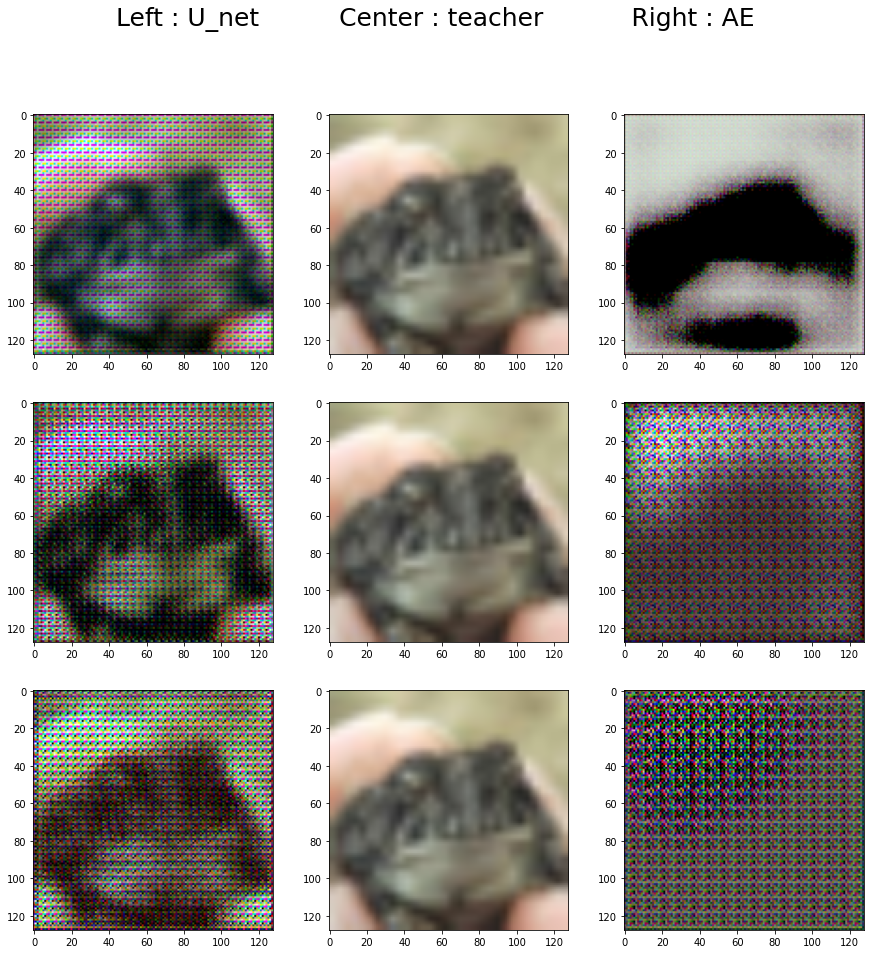

In [ ]:
# U_net, batch_size(100, 500, 1000)
model_True_100 = Model(64, True)
model_True_500 = Model(64, True)
model_True_1000 = Model(64, True)
t_100 = model_True_100.load_state_dict(torch.load('u_net_True_100.pth'))
t_500 = model_True_500.load_state_dict(torch.load('u_net_True_500.pth'))
t_1000 = model_True_1000.load_state_dict(torch.load('u_net_True_1000.pth'))

# AE, batch_size(100, 500, 1000)
model_False_100 = Model(64, False)
model_False_500 = Model(64, False)
model_False_1000 = Model(64, False)
f_100 = model_False_100.load_state_dict(torch.load('u_net_False_100.pth'))
f_500 = model_False_500.load_state_dict(torch.load('u_net_False_500.pth'))
f_1000 = model_False_1000.load_state_dict(torch.load('u_net_False_1000.pth'))


models = [[model_True_100, model_False_100],
          [model_True_500, model_False_500],
          [model_True_1000, model_False_1000]]


# イメージの選択と描画
id = 25
target = x_trains[0][id].reshape(-1, 3, 64, 64)
teacher = y_trains[0][id]
fig = plt.figure(figsize=(15, 15))
plt.suptitle('Left : U_net          Center : teacher           Right : AE', fontsize=25)
for i, img in enumerate(models):
    t = img[0](target)
    f = img[1](target)

    t = t.to('cpu').detach().numpy().copy()
    f = f.to('cpu').detach().numpy().copy()

    pre_t = np.transpose(t[0], (1,2,0))
    pre_f = np.transpose(f[0], (1,2,0))

    ax1 = fig.add_subplot(3,3,(i+1)*3-2)
    ax1.imshow(pre_t)

    ax2 = fig.add_subplot(3,3,(i+1)*3-1)
    ax2.imshow(np.transpose(teacher, (1,2,0)))

    ax3 = fig.add_subplot(3,3,(i+1)*3)
    ax3.imshow(pre_f)

## 考察
AEで生成された画像は教師データに対して似つかないものとなった. <br>対してU_Netではしっかりと教師データの特徴を捉えた画像が生成されている. <br>batch_sizeについては今回のデータ数であれば小さいほど教師データの特徴をしっかり取られているようである. 
<br><br>
ただU_Netのモデルでは画像の特徴を捉えているがノイズがひどい. <br>教師データにより近づけるためには, 意図的に学習データにノイズを混ぜてDenoisingさせる必要がある.
<br><br>
高解像度化のモデルを作成するには, やはり高解像度画像を教師データにする必要があると感じる.<br>次回は訓練データに高解像度画像をダウンサンプルし, 一様にノイズを混ぜたものを使用してモデルを作成することで改善を図りたい.
